In [36]:
import json
import os
import numpy as np
import matplotlib.pyplot as plt
import matplotlib
matplotlib.rcParams['pdf.fonttype'] = 42
matplotlib.rcParams['ps.fonttype'] = 42
plt.rcParams['figure.figsize'] = [20,20]

In [30]:
def prot_div(left, right):
    if right == 0:
        return 0
    else:
        return left / right

def if_func(condition, state1, state2):
    if condition:
        return state1
    else:
        return state2

def read_experiment_results(full_path, iterations, epochs=100):
    dir_name = full_path
    results = []
    for it in range(iterations):
        with open(dir_name + 'iteration_' + str(it) + '.json') as json_file:
            if it % 10 == 0:
                print(it)
            data = json.load(json_file)
            results.append(data)
    print("Finished reading ", full_path)
    return results


In [31]:
run_number = ['8']
iterations = 495
os_string = "osx"
results = []
if os_string == "osx":
    path = "/Users/soren/Google Drive/My Drive/results/autolr-2022-06-30/run_"
elif os_string == "w10":
    path = "G:\\My Drive\\results\\autolr-2022-05-25\\run_"
for i in run_number: 
    results.append(read_experiment_results(path + i + '/', iterations))


0
10
20
30
40
50
60
70
80
90
100
110
120
130
140
150
160
170
180
190
200
210
220
230
240
250
260
270
280
290
300
310
320
330
340
350
360
370
380
390
400
410
420
430
440
450
460
470
480
490
Finished reading  /Users/soren/Google Drive/My Drive/results/autolr-2022-06-30/run_8/


In [32]:
from smart_phenotype import smart_phenotype
import random
def genealogy_string(results):
    import graphviz
    epochs = np.arange(len(results[0]))
    lineage = []
    fitness_color = []
    occurences = {}
    rendered = set()
    prune_cutoff = 20
    string = """digraph genealogy{
fontname="Helvetica,Arial,sans-serif"
node [fontname="Helvetica,Arial,sans-serif"]
edge [fontname="Helvetica,Arial,sans-serif"]
# page = "8.2677165,11.692913" ;
ratio = "auto" ;
mincross = 2.0 ;
label = "Genealogy" ;


"""
    connections_string = ""
    for iteration in epochs:     
        for result in results:
            for indiv in result[iteration]:
                if "parent" in indiv:
                    for parent in indiv["parent"]:
                        if parent in occurences:
                            occurences[parent] += 1
                        else: 
                            occurences[parent] = 1
                        if indiv['id'] in occurences:
                            occurences[indiv['id']] += 1
                        else: 
                            occurences[indiv['id']] = 1  
                        lineage.append((parent, indiv['id'], indiv['fitness'] * -1))
                fitness_color.append((indiv['id'], indiv['fitness'] * -1))
    for parent, child, fitness in set(lineage):
        if fitness > 0.12 and occurences[parent] > prune_cutoff and occurences[child] > prune_cutoff:
            connections_string+=(f'\n "{parent}" -> "{child}" ;')    
            rendered.add(parent)
            rendered.add(child)
    for id, fitness in set(fitness_color):
        if fitness > 0.12 and id in rendered:
            string+=(f'\n "{id}" [style=filled,fillcolor="#{format(int(255-fitness*255), "x")}{format(int(255-fitness*255), "x")}ff", width={fitness*10}, height={fitness*10}] ;')

    string += connections_string + "\n }"
    with open("graph.dot", "w") as f:
        print(string,file=f)
    src = graphviz.Source(string)
    src.render('doctest-output/graph.gv', view=True).replace('\\', '/')
    return string

#print(genealogy_string(results))


In [40]:
def heatmap(data, row_labels, col_labels, ax=None,
            cbar_kw={}, cbarlabel="", **kwargs):
    """
    Create a heatmap from a numpy array and two lists of labels.

    Parameters
    ----------
    data
        A 2D numpy array of shape (M, N).
    row_labels
        A list or array of length M with the labels for the rows.
    col_labels
        A list or array of length N with the labels for the columns.
    ax
        A `matplotlib.axes.Axes` instance to which the heatmap is plotted.  If
        not provided, use current axes or create a new one.  Optional.
    cbar_kw
        A dictionary with arguments to `matplotlib.Figure.colorbar`.  Optional.
    cbarlabel
        The label for the colorbar.  Optional.
    **kwargs
        All other arguments are forwarded to `imshow`.
    """

    if not ax:
        ax = plt.gca()

    # Plot the heatmap
    im = ax.imshow(data, **kwargs)

    # Create colorbar
    cbar = ax.figure.colorbar(im, ax=ax, **cbar_kw)
    cbar.ax.set_ylabel(cbarlabel, rotation=-90, va="bottom")

    # Show all ticks and label them with the respective list entries.
    ax.set_xticks(np.arange(data.shape[1]), labels=col_labels)
    ax.set_yticks(np.arange(data.shape[0]), labels=row_labels)

    # Let the horizontal axes labeling appear on top.
    ax.tick_params(top=True, bottom=False,
                   labeltop=True, labelbottom=False)

    # Rotate the tick labels and set their alignment.
    plt.setp(ax.get_xticklabels(), rotation=-30, ha="right",
             rotation_mode="anchor")

    # Turn spines off and create white grid.
    ax.spines[:].set_visible(False)

    ax.set_xticks(np.arange(data.shape[1]+1)-.5, minor=True)
    ax.set_yticks(np.arange(data.shape[0]+1)-.5, minor=True)
    ax.grid(which="minor", color="w", linestyle='-', linewidth=3)
    ax.tick_params(which="minor", bottom=False, left=False)

    return im, cbar

def annotate_heatmap(im, data=None, valfmt="{x:.2f}",
                     textcolors=("black", "white"),
                     threshold=None, **textkw):
    """
    A function to annotate a heatmap.

    Parameters
    ----------
    im
        The AxesImage to be labeled.
    data
        Data used to annotate.  If None, the image's data is used.  Optional.
    valfmt
        The format of the annotations inside the heatmap.  This should either
        use the string format method, e.g. "$ {x:.2f}", or be a
        `matplotlib.ticker.Formatter`.  Optional.
    textcolors
        A pair of colors.  The first is used for values below a threshold,
        the second for those above.  Optional.
    threshold
        Value in data units according to which the colors from textcolors are
        applied.  If None (the default) uses the middle of the colormap as
        separation.  Optional.
    **kwargs
        All other arguments are forwarded to each call to `text` used to create
        the text labels.
    """

    if not isinstance(data, (list, np.ndarray)):
        data = im.get_array()

    # Normalize the threshold to the images color range.
    if threshold is not None:
        threshold = im.norm(threshold)
    else:
        threshold = im.norm(data.max())/2.

    # Set default alignment to center, but allow it to be
    # overwritten by textkw.
    kw = dict(horizontalalignment="center",
              verticalalignment="center")
    kw.update(textkw)

    # Get the formatter in case a string is supplied
    if isinstance(valfmt, str):
        valfmt = matplotlib.ticker.StrMethodFormatter(valfmt)

    # Loop over the data and create a `Text` for each "pixel".
    # Change the text's color depending on the data.
    texts = []
    for i in range(data.shape[0]):
        for j in range(data.shape[1]):
            kw.update(color=textcolors[int(im.norm(data[i, j]) > threshold)])
            text = im.axes.text(j, i, valfmt(data[i, j], None), **kw)
            texts.append(text)

    return texts


0


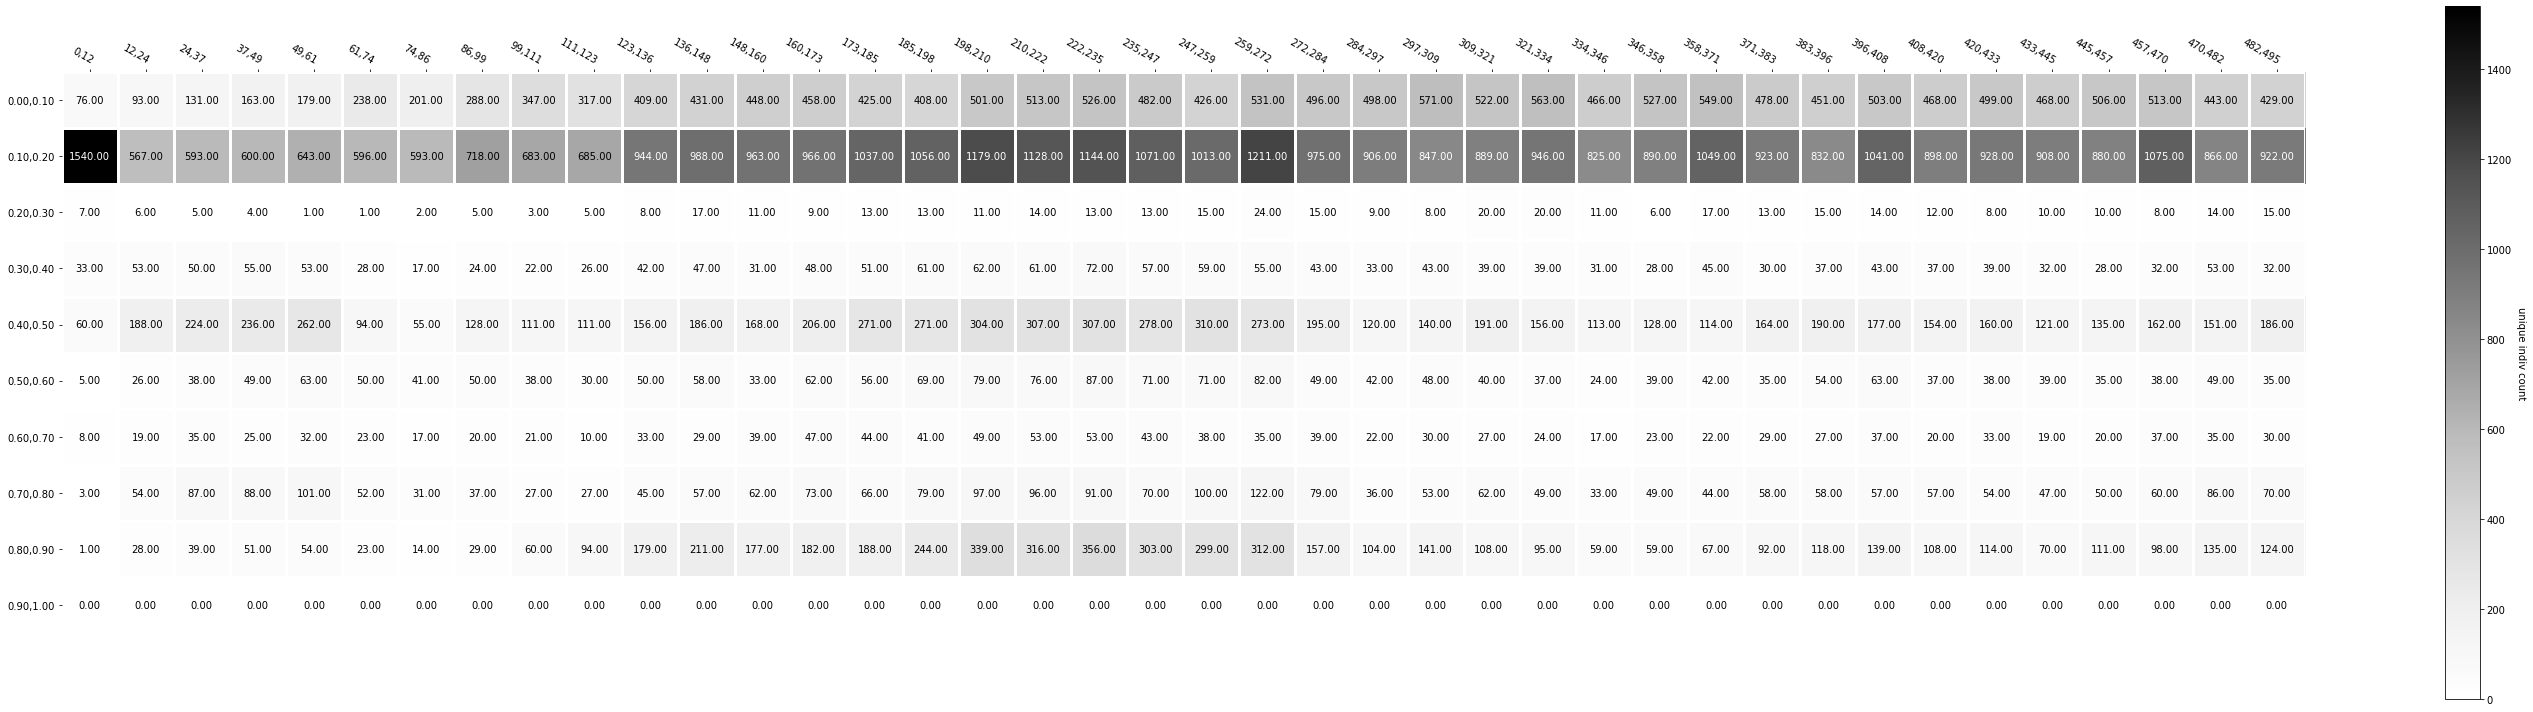

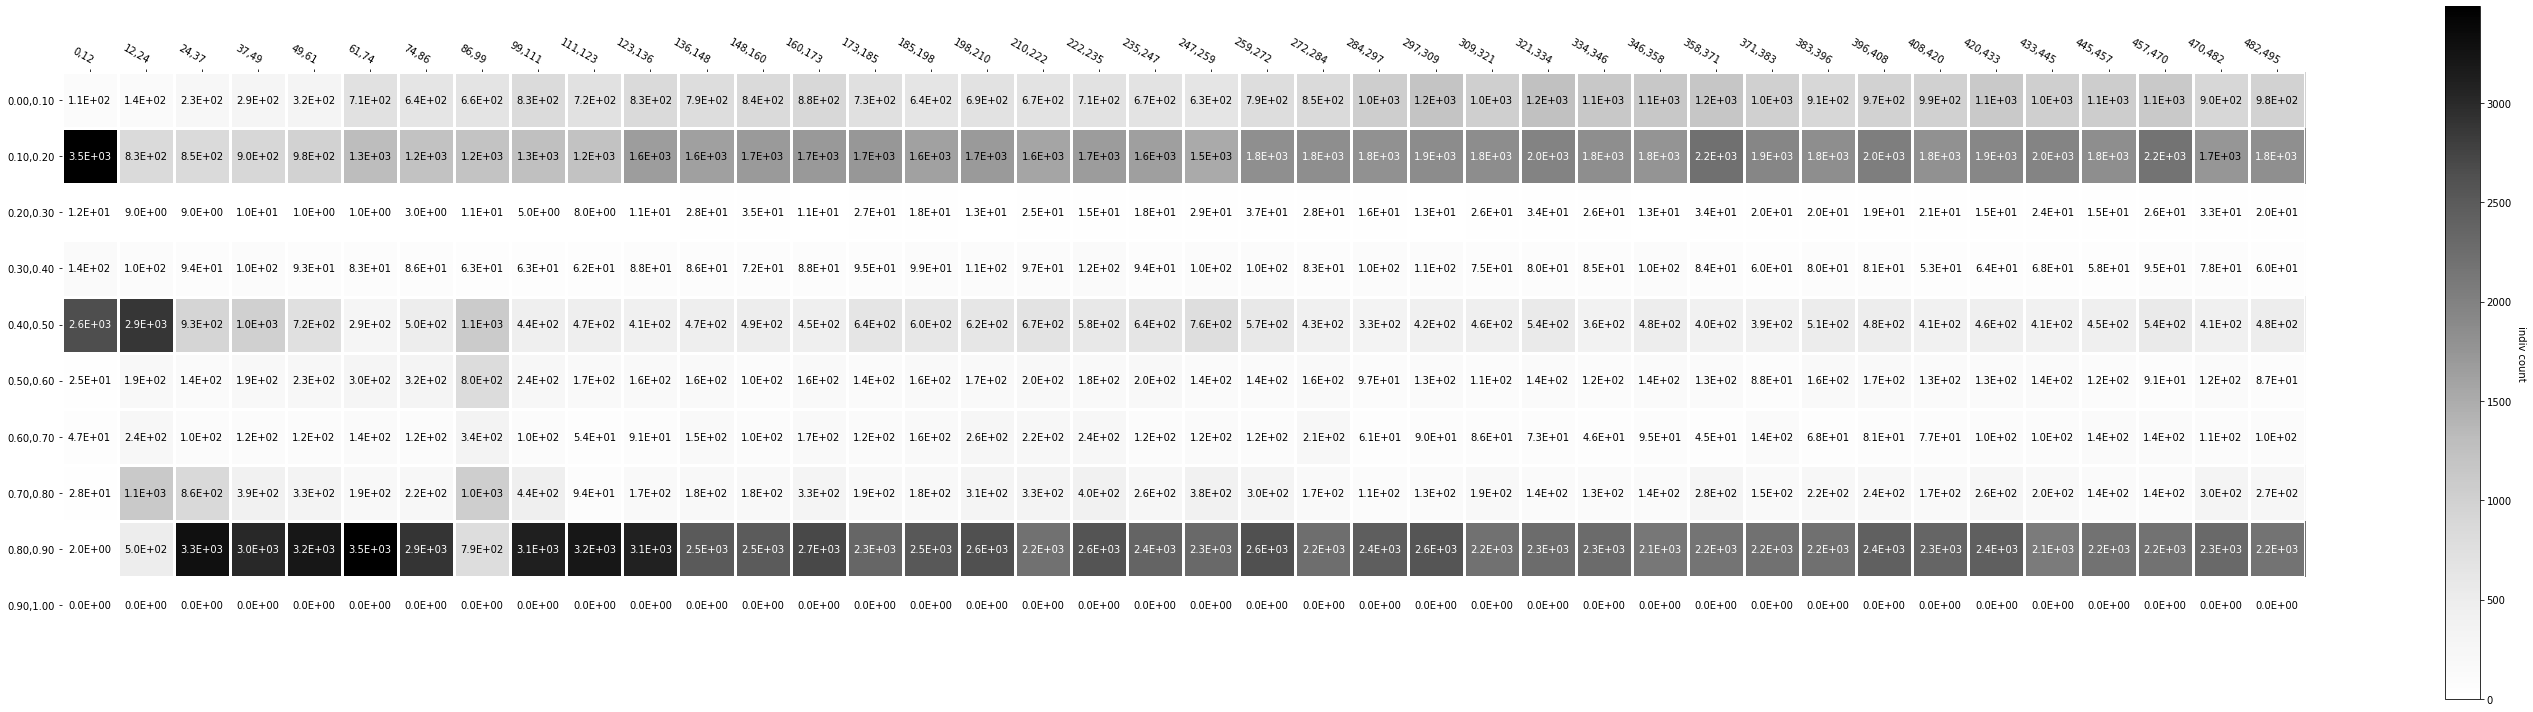

In [47]:
def process_results(results, negative_fit=True):
    epochs = np.arange(len(results[0]))
    #print(epochs)
    best_individuals = {}
    averages_all = []
    bests_all = []
    stds_all = []
    best_of_all = []
    stds_best_all = [] 
    indivs = []
    indiv_fits = []
    indivs_epochs = []
    indivs_per_epoch = []
    boa_fit = 0
    boa_indiv = None
    for iteration in epochs:
        averages_all.append([])
        bests_all.append([])
        stds_all.append([])
        indivs_per_epoch.append([])
        best_of_all.append(0)
        stds_best_all.append(0)        
        for result in results:
            all_fits = []
            best = 0
            gen_best = 0
            for indiv in result[iteration]:
                if negative_fit:
                    indiv["fitness"] *= -1
                indivs.append(indiv)
                indiv_fits.append(indiv['fitness'])
                indivs_epochs.append(iteration)
                indivs_per_epoch[iteration].append(indiv['fitness'])
                if indiv['fitness'] > best:
                    best = indiv['fitness']
                    if indiv['fitness'] > boa_fit:
                        boa_fit = best
                        #print(f'------NEW BEST------\n{iteration}-{indiv["id"]}-{boa_fit}\n{smart_phenotype(indiv["phenotype"])}\n--------------------')
                        best_individuals[iteration] = {"fitness": boa_fit, "phenotype": indiv["phenotype"], "smart_phenotype": smart_phenotype(indiv["phenotype"])}
                best = best if indiv['fitness'] < best else indiv['fitness']
                all_fits.append(indiv['fitness'])
            averages_all[iteration].append(np.average(all_fits))
            stds_all[iteration].append(np.std(all_fits))
            bests_all[iteration].append(best)
        stds_best_all[iteration] = np.std(bests_all[iteration]) 
        stds_all[iteration] = np.std(averages_all[iteration])
        averages_all[iteration] = np.average(averages_all[iteration])
        best_of_all[iteration] = np.max(bests_all[iteration])  
        bests_all[iteration] = np.average(bests_all[iteration])
    return {"averages_all": averages_all, "bests_all": bests_all, "indivs": indivs, "indivs_epochs": indivs_epochs, "epochs": epochs}

def plot_fit(epochs, averages_all, bests_all): 
    plt.figure(facecolor='#eff2f1')
    
    ax = plt.axes()
    ax.set_facecolor(color="#eff2f1")
    ax.spines['bottom'].set_color('#08415c')
    ax.spines['top'].set_color('#08415c')
    ax.spines['left'].set_color('#08415c')
    ax.spines['right'].set_color('#08415c')
    ax.xaxis.label.set_color('#08415c')
    ax.yaxis.label.set_color('#08415c')
    ax.tick_params(axis='x', colors='#08415c')
    ax.tick_params(axis='y', colors="#08415c")
    plt.plot(epochs, averages_all, label='population average', color="#7796cb")
    #plt.fill_between(epochs, [i + j for i, j in zip(averages_all, stds_all)], [i - j for i, j in zip(averages_all, stds_all)], alpha=0.2)
    plt.plot(epochs, bests_all, label='best average', color="#EFA00B")   
    #plt.fill_between(epochs, [i + j for i, j in zip(bests_all, stds_best_all)], [i - j for i, j in zip(bests_all, stds_best_all)], alpha=0.2)
    plt.xlabel('Generation')
    plt.ylabel('Accuracy')
    plt.savefig(f'best_average_evolution{run_number}.png')
    plt.savefig(f'best_average_evolution{run_number}.pdf')
    plt.show()

def pop_density_heatmap(epochs, indivs, rows=10, columns=10, fit_floor=0, fit_ceil=1, epoch_len=100):
    heatmap_matrix = np.zeros((rows, columns), dtype=np.int32)
    fit_range = fit_ceil - fit_floor
    row_labels = [f"{(fit_range) / rows * x + fit_floor:.2f},{(fit_range) / rows * (x + 1) + fit_floor:.2f}" for x in range(rows)]
    columns_labels = [f"{int((epoch_len) / columns * x)},{int((epoch_len) / columns * (x + 1))}" for x in range(columns)]
    for epoch, indiv in zip(epochs, indivs):
        if indiv["fitness"] >= fit_floor and indiv["fitness"] <= fit_ceil:
            row_index = int((indiv["fitness"] - fit_floor) / fit_range * rows)
            column_index = int(float(epoch) / float(epoch_len) * columns)
            heatmap_matrix[row_index][column_index] += 1
    fig, ax = plt.subplots()
    im, cbar = heatmap(heatmap_matrix, row_labels, col_labels=columns_labels, ax=ax, cbarlabel="indiv count", cmap="Greys")
    texts = annotate_heatmap(im,valfmt="{x:.1E}")
    fig.tight_layout()
    plt.show()

def unique_indivs_heatmap(epochs, indivs, rows=10, columns=10, fit_floor=0, fit_ceil=1, epoch_len=100):
    heatmap_matrix = np.zeros((rows, columns), dtype=np.int32)
    unique_indivs_record = {}
    fit_range = fit_ceil - fit_floor
    row_labels = [f"{(fit_range) / rows * x + fit_floor:.2f},{(fit_range) / rows * (x + 1) + fit_floor:.2f}" for x in range(rows)]
    columns_labels = [f"{int((epoch_len) / columns * x)},{int((epoch_len) / columns * (x + 1))}" for x in range(columns)]
    for epoch, indiv in zip(epochs, indivs):
        if indiv["fitness"] >= fit_floor and indiv["fitness"] <= fit_ceil:
            row_index = int((indiv["fitness"] - fit_floor) / fit_range * rows)
            column_index = int(float(epoch) / float(epoch_len) * columns)
            if row_index not in unique_indivs_record:
                unique_indivs_record[row_index] = {}
            if column_index not in unique_indivs_record[row_index]:
                unique_indivs_record[row_index][column_index] = []
            if indiv["smart_phenotype"] not in unique_indivs_record[row_index][column_index]:
                unique_indivs_record[row_index][column_index].append(indiv["smart_phenotype"])
                heatmap_matrix[row_index][column_index] += 1
    fig, ax = plt.subplots()
    im, cbar = heatmap(heatmap_matrix, row_labels, col_labels=columns_labels, ax=ax, cbarlabel="unique indiv count", cmap="Greys")
    texts = annotate_heatmap(im)
    fig.tight_layout()
    plt.show()

columns, rows = (40, 10)
plt.rcParams['figure.figsize'] = [columns, rows]
data = process_results(results)
print(data['epochs'][0])
#plot_fit(data["epochs"], data['averages_all'], data['bests_all'])
unique_indivs_heatmap(data["indivs_epochs"], data["indivs"], rows=rows, columns=columns, fit_floor=0.0, fit_ceil=1.0, epoch_len=len(data["epochs"]))
pop_density_heatmap(data["indivs_epochs"], data["indivs"], rows=rows, columns=columns, fit_floor=0.0, fit_ceil=1.0, epoch_len=len(data["epochs"]))